# **Finding Lane Lines on the Road** 
***
In this project, we will use computer vision techniques to identify lane lines on road images. The tools we will use are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  


In [1]:
#import libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


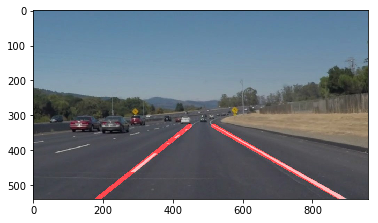

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

Set up Computer Vision functions to be used in pipeline.

In [3]:
import math

def grayscale(img):
    # Applies the Grayscale transform
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    # Applies the Canny transform
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    # Applies a Gaussian Noise kernel
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):

    """ This function applies an image mask. It only keeps the region of the image defined by 
    the polygon formed from `vertices`. The rest of the image is set to black. """
    
    # defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=12):
    
    """ This function draws `lines` with `color` and `thickness`    
    over the lines found in images. """
    
    #we draw 2 lines in the road.     
    #create 4 vectors for the lines: x,y coordinates for left line, right line.
    lv_x = []
    lv_y = []
    rv_x = []
    rv_y = []

    #go through all line segments returned from HoughLinesP function
    for line in lines:
        for x1,y1,x2,y2 in line:
            #seperate line segments by left line, right line.
            #M=slope of line segment, will determine whether right line or left line
            M = ((y2 - y1)/(x2-x1))
            #values .45, .85 determined by range of acceptatable slopes to left line and right line.
            if M < -0.45 and M > -0.85:
                lv_x = np.append(lv_x, x1)
                lv_y = np.append(lv_y, y1)
                lv_x = np.append(lv_x, x2)
                lv_y = np.append(lv_y, y2)                
            if M > 0.45 and M < 0.85:
                rv_x = np.append(rv_x, x1)
                rv_y = np.append(rv_y, y1)
                rv_x = np.append(rv_x, x2)
                rv_y = np.append(rv_y, y2) 
                
    #get coefficient vector [M, b] - slope intercept for left line, right line.      
    lcv =  np.polyfit(lv_x, lv_y, 1)
    rcv =  np.polyfit(rv_x, rv_y, 1)
    
    #plot line segments based on slope, intercept and points we know (max and min y values) for
    #left line and right.
    ly1 = 540
    lx1 = int((ly1 - lcv[1])/lcv[0])
    ly2 = 330
    lx2 = int((ly2 - lcv[1])/lcv[0])
    ry1 = 540
    rx1 =  int((ry1 - rcv[1])/rcv[0])
    ry2 = 330
    rx2 = int((ry2 - rcv[1])/rcv[0])
    
    #print line segments on image.
    cv2.line(img, (lx1, ly1), (lx2, ly2), color, thickness)
    cv2.line(img, (rx1, ry1), (rx2, ry2), color, thickness)
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    
    """ `img` is the output of a Canny transform.    
    This function returns an image with hough lines drawn. """
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):

    """ `img` is the output of the hough_lines(), an image with lines drawn on it. 
    `initial_img` is an image before any processing. The result image is computed as follows:
    initial_img * α + img * β + λ """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

First we test the pipeline on static images.   


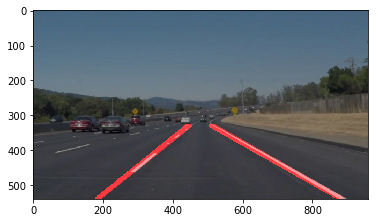

In [4]:
# Use the functions above to test our pipeline on static images.

# convert image to one color - gray.
gray = grayscale(image)

# apply guassian_blur to cut down noise in image.
kernal_size = 5
blur_gray = gaussian_blur(gray, kernal_size)

# set canny edge detection thresholds so edges are detected by differences in pixel brightness.
low_threshold = 50
high_threshold = 150
edges = canny(blur_gray, low_threshold, high_threshold)

# Next we'll create a masked edges image using cv2.fillPoly()
# 0 is darkest, 255 is brightest
mask = np.zeros_like(edges)   #returns array of zeros, same shape and size as edges image.
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(100, imshape[0]),(430, 330), (530, 330), (940,imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color) #will change mask array to 0 for all values outside poly.
masked_edges = cv2.bitwise_and(edges, mask) #new edges array with everything outside poly black=0.

# remember canny transform highlights brightness differences in pixels. We still need to connect these 
# pixels to create line segments. We use the HoughTransformP to do this.

# HoughTransform parameters:
# convert the x, y coordinates of image space to polar coordinates of parameter space.
rho = 2
theta = np.pi/180

# threshold - minimum points to consider line segment.
# min_line_length - minimum length of line to draw, includes gaps.
# max length of gap to be considered as part of a line segments.
threshold = 15
min_line_length = 30
max_line_gap = 5

# get line segments from probabalistic HoughTransformP and call draw_lines function to draw extended
# line segments for left line and right line.
line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
# combine image with drawnlines with original color image.
combo = weighted_img(line_img, image)
plt.imshow(combo)
color_select = combo

# mpimg.imsave('test_images/solidWhiteCurve.jpg', color_select) - if desired, save image.


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(image):
    
    # please see individual image pipeline for explanation of code below.
    gray = grayscale(image)

    kernal_size = 5
    blur_gray = gaussian_blur(gray, kernal_size)

    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(100, imshape[0]),(430, 330), (530, 330), (940,imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)


    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_length = 20
    max_line_gap = 5


    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    combo = weighted_img(line_img, image)
    result = combo
    
    return result

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

And that's it! Hough line segments have been drawn onto the road... Of course we can make our project more robust. Another project? - try Advanced Lane Lines. Cheers!